<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">

# Python for Algorithmic Trading
## Efficient Markets, Random Walks, and Statistical Tests

&copy; Dr. Yves J. Hilpisch<br>
AI-Powered by GPT 5.1<br>
The Python Quants GmbH | https://tpq.io<br>
https://hilpisch.com | https://linktr.ee/dyjh


## Notebook Goals

This notebook complements Section 2 of the article by turning the discussion of the Efficient Market Hypothesis (EMH), random walks, and basic tests for predictability into executable Python code. You will

- simulate random-walk price paths and log-returns,
- visualize distributions and paths as a benchmark for ``unpredictable'' markets,
- compute and interpret autocorrelations of returns, and
- run simple hypothesis tests for linear predictability.

The focus is on intuition: what an efficient market implies for time-series patterns, and how departures from these patterns show up in diagnostics.

In [1]:
# Core imports for EMH experiments.

import numpy as np  #  numerical arrays and random sampling
import pandas as pd  #  labelled time series
import matplotlib.pyplot as plt  #  plotting
from pathlib import Path  #  convenient filesystem paths

plt.style.use("seaborn-v0_8")  #  consistent plotting style
plt.rcParams.update({"figure.dpi": 150})  #  sharper inline figures


## 1. Simulating Random Walks

We start from the geometric random-walk benchmark used throughout the article. Returns are i.i.d. normal and prices are the cumulative product of gross returns.

In [2]:
def simulate_random_walk(steps: int = 252,
                         paths: int = 10,
                         mu: float = 0.0,
                         sigma: float = 0.02,
                         s0: float = 100.0) -> tuple[np.ndarray, np.ndarray]:
    """Simulate geometric random-walk prices and log-returns.

    Parameters
    ----------
    steps : int
        Number of time steps to simulate (for example, trading days).
    paths : int
        Number of independent random-walk paths.
    mu : float
        Drift of the log-return process.
    sigma : float
        Volatility of the log-return process.
    s0 : float
        Initial price level for all paths.

    Returns
    -------
    prices : ndarray
        Simulated price paths of shape (steps, paths).
    log_returns : ndarray
        Simulated log-returns of shape (steps, paths).
    """

    rng = np.random.default_rng(seed=42)  #  reproducible randomness
    log_returns = rng.normal(mu, sigma, size=(steps, paths))  #  i.i.d. shocks
    log_returns[0] = 0.0  #  first step keeps price at s0
    prices = s0 * np.exp(log_returns.cumsum(axis=0))  #  geometric random walk
    return prices, log_returns


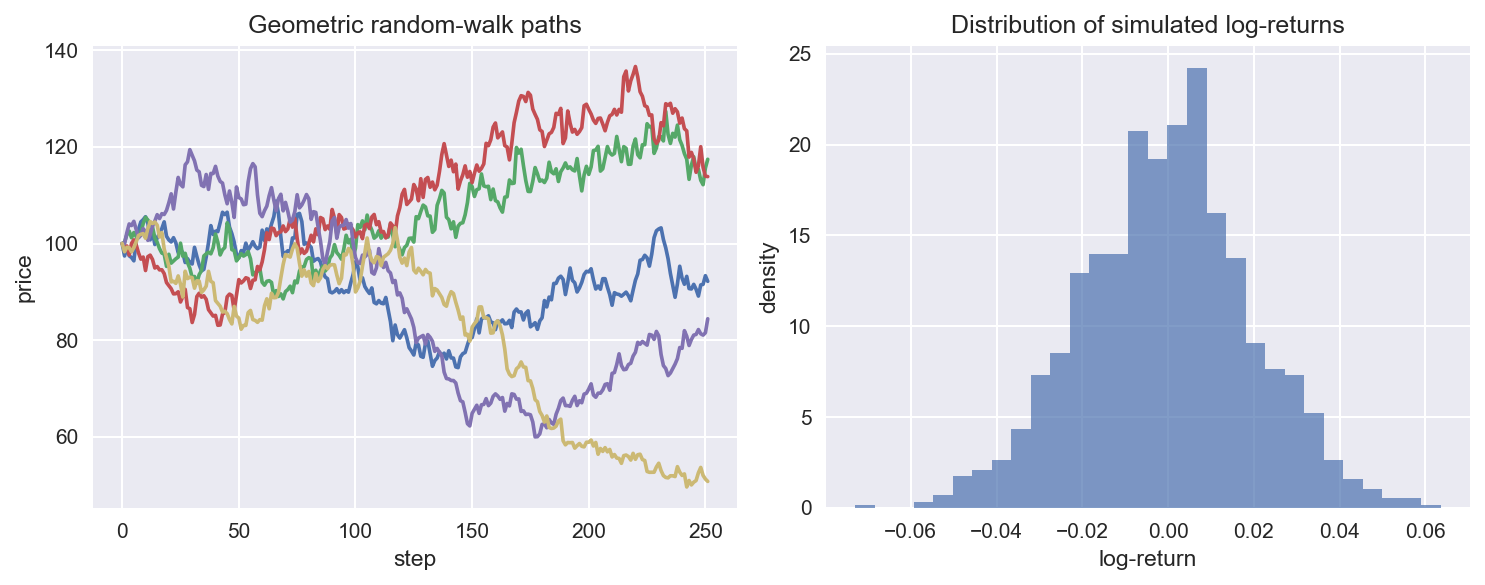

In [3]:
prices, log_rets = simulate_random_walk(steps=252, paths=5)
days = np.arange(prices.shape[0])  #  integer time index

fig, (ax_price, ax_hist) = plt.subplots(1, 2, figsize=(10, 4))

ax_price.plot(days, prices)
ax_price.set_xlabel("step")
ax_price.set_ylabel("price")
ax_price.set_title("Geometric random-walk paths")

ax_hist.hist(log_rets.ravel(), bins=30, density=True, alpha=0.7)
ax_hist.set_xlabel("log-return")
ax_hist.set_ylabel("density")
ax_hist.set_title("Distribution of simulated log-returns")

fig.tight_layout()
plt.show()


## 2. Autocorrelations and Linear Predictability

In an ideal EMH world, return autocorrelations should be statistically indistinguishable from zero. Next we compute and plot sample autocorrelations for both efficient and predictable return series.

In [4]:
def simulate_ar1(steps: int = 500,
                 rho: float = 0.0,
                 sigma: float = 0.02) -> np.ndarray:
    """Simulate AR(1) returns r_t = rho * r_{t-1} + eps_t."""

    rng = np.random.default_rng(seed=3)
    eps = rng.normal(0.0, sigma, size=steps)  #  innovation shocks
    r = np.empty(steps)
    r[0] = eps[0]  #  start at noise level
    for t in range(1, steps):
        r[t] = rho * r[t - 1] + eps[t]  #  AR(1) recursion
    return r


def autocorr(x: np.ndarray, max_lag: int = 12) -> np.ndarray:
    """Compute sample autocorrelations up to a given lag."""

    x_centered = x - x.mean()  #  remove sample mean
    denom = np.dot(x_centered, x_centered)  #  variance * (n - 1)
    acf = np.empty(max_lag)
    for k in range(1, max_lag + 1):
        num = np.dot(x_centered[:-k], x_centered[k:])  #  lag-k covariance
        acf[k - 1] = num / denom  #  sample autocorrelation at lag k
    return acf


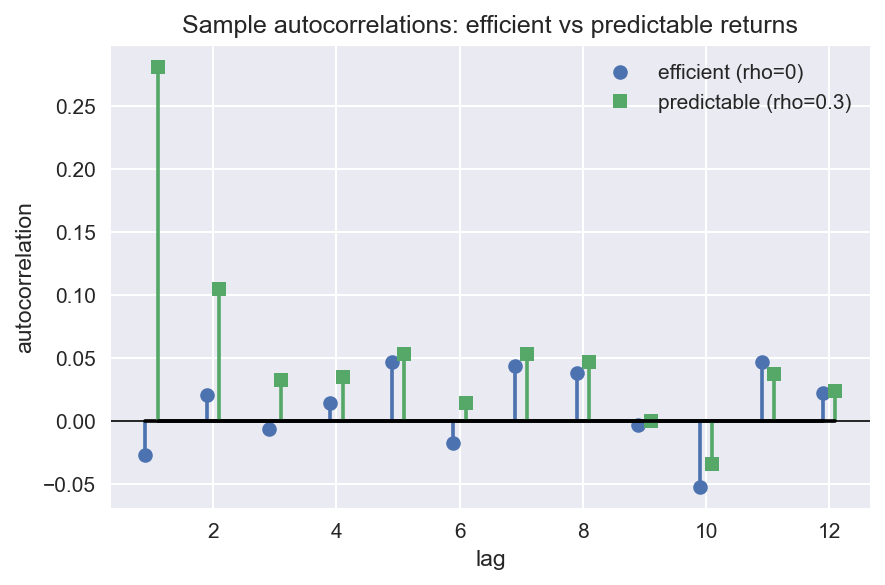

In [5]:
r_eff = simulate_ar1(rho=0.0)
r_pred = simulate_ar1(rho=0.3)

acf_eff = autocorr(r_eff, max_lag=12)
acf_pred = autocorr(r_pred, max_lag=12)
lags = np.arange(1, 13)

fig, ax = plt.subplots(figsize=(6, 4))
eff_stem = ax.stem(lags - 0.1, acf_eff,
                   linefmt="C0-", markerfmt="C0o", basefmt="k-")
pred_stem = ax.stem(lags + 0.1, acf_pred,
                    linefmt="C1-", markerfmt="C1s", basefmt="k-")
ax.axhline(0.0, color="black", linewidth=0.8)
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
ax.set_title("Sample autocorrelations: efficient vs predictable returns")
ax.legend([eff_stem.markerline, pred_stem.markerline],
          ["efficient (rho=0)", "predictable (rho=0.3)"])
fig.tight_layout()
plt.show()


## 3. Simple Hypothesis Tests

Finally we wrap the diagnostics into simple hypothesis tests: a regression of returns on their own lags and a rough t-test for the first-lag coefficient. For more serious work you would reach for `statsmodels`, but the hand-rolled version keeps the link to the underlying math transparent.

In [6]:
def ar1_ols_test(r: np.ndarray) -> dict[str, float]:
    """Estimate r_t = a + b r_{t-1} + e_t and report t-stat for b.

    This is *not* a full-fledged time-series test, but it gives
    a first sense of whether there is economically meaningful
    linear predictability at lag 1.
    """

    y = r[1:]  #  current returns
    x = r[:-1]  #  lagged returns
    X = np.column_stack([np.ones_like(x), x])  #  intercept and lag
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    resid = y - y_hat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)  #  residual variance estimate
    XtX_inv = np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(sigma2 * XtX_inv))  #  standard errors
    t_b = beta[1] / se_beta[1]  #  t-statistic for lag-1 coefficient
    return {"beta_lag1": float(beta[1]), "t_stat": float(t_b)}


for rho in (0.0, 0.3):
    stats = ar1_ols_test(simulate_ar1(rho=rho))
    print(f"rho={rho:.1f} -> beta_lag1={stats['beta_lag1']:.3f}, t={stats['t_stat']:.2f}")


rho=0.0 -> beta_lag1=-0.027, t=-0.60
rho=0.3 -> beta_lag1=0.282, t=6.57


## 4. Where to Go Next

The random-walk simulations and autocorrelation tests in this notebook provide a baseline for later strategy work:

- Vectorized and event-based backtests in subsequent notebooks should be compared against the ``no-predictability'' scenario built here.
- The same testing patterns can be applied to real EURUSD returns to probe for linear predictability.
- More advanced diagnostics—such as Ljung--Box tests or Granger-causality analysis—build on the same regression and autocorrelation foundations.


<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">